# 分布式 Logistic 回归模型

### 1. 准备工作

配置和启动 PySpark：

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
# 本地模式
spark = SparkSession.builder.\
    master("local[*]").\
    appName("Logistic Regression").\
    getOrCreate()
sc = spark.sparkContext
# sc.setLogLevel("ERROR")
print(spark)
print(sc)

<SparkContext master=local[*] appName=Logistic Regression>


假设 $n\gg p$，利用 Numpy 生成模拟数据，并写入文件。

In [2]:
import os
import numpy as np
from scipy.special import expit, logit
np.set_printoptions(linewidth=100)

np.random.seed(123)
n = 100000
p = 100
x = np.random.normal(size=(n, p))
beta = np.random.normal(size=p)
prob = expit(x.dot(beta))  # p = 1 / (1 + exp(-x * beta))
y = np.random.binomial(1, prob, size=n)
dat = np.hstack((y.reshape(n, 1), x))
if not os.path.exists("data"):
    os.makedirs("data", exist_ok=True)
np.savetxt("data/logistic.txt", dat, fmt="%f", delimiter="\t")

其中 `expit()` 即 Sigmoid 函数，表达式为 $\rho(x)=1/(1+e^{-x})$。 

PySpark 读取文件并进行一些简单操作：

In [3]:
file = sc.textFile("data/logistic.txt")  # 注意查看数据，然后看一下如何分隔，可以通过打印第一行

# 打印矩阵行数
print(file.count())

# 空行
print()

# 打印前5行，并将每行字符串截尾
text = file.map(lambda x: x[:70] + "...").take(5)
print(*text, sep="\n")

100000

0.000000	-1.085631	0.997345	0.282978	-1.506295	-0.578600	1.651437	-2.4...
1.000000	0.642055	-1.977888	0.712265	2.598304	-0.024626	0.034142	0.179...
0.000000	0.703310	-0.598105	2.200702	0.688297	-0.006307	-0.206662	-0.0...
1.000000	0.765055	-0.828989	-0.659151	0.611124	-0.144013	1.316606	-0.7...
0.000000	1.534090	-0.529914	-0.490972	-1.309165	-0.008660	0.976813	-1....


### 2. 牛顿法迭代

Logistic 回归的系数估计没有显式解，但可以利用牛顿法迭代。参见 [https://online.stat.psu.edu/stat508/lesson/9/9.1/9.1.2](https://online.stat.psu.edu/stat508/lesson/9/9.1/9.1.2)。

迭代公式为 $\beta^{new}=(X'WX)^{-1}X'Wz$，其中 $z=X\beta^{old}+W^{-1}(y-prob)$，$prob$ 是 $\rho(X\beta^{old})$ 组成的向量，$W$ 是以 $prob\cdot (1-prob)$ 为对角线元素的对角矩阵。

当 $n\gg p$ 且 $p$ 不太大时，$X'WX$ 为 $p\times p$ 矩阵，$X'Wz$ 为 $p\times 1$ 向量，均可放入内存。因此，此时问题的核心在于计算 $X'WX$ 与 $X'Wz$。

首先进行分区映射：

In [4]:
# file = file.repartition(10)
print(file.getNumPartitions())

3


In [5]:
# str => np.array
def str_to_vec(line):
    # 分割字符串
    str_vec = line.split("\t")
    # 将每一个元素从字符串变成数值型
    num_vec = map(lambda s: float(s), str_vec)
    # 创建 Numpy 向量
    return np.fromiter(num_vec, dtype=float)

# Iter[str] => Iter[matrix]
def part_to_mat(iterator):
    # Iter[str] => Iter[np.array]
    iter_arr = map(str_to_vec, iterator)

    # Iter[np.array] => list(np.array)
    dat = list(iter_arr)

    # list(np.array) => matrix
    if len(dat) < 1:  # Test zero iterator
        mat = np.array([])
    else:
        mat = np.vstack(dat)

    # matrix => Iter[matrix]
    yield mat

In [6]:
dat = file.mapPartitions(part_to_mat).filter(lambda x: x.shape[0] > 0)
print(dat.count())
dat.cache()

3


PythonRDD[5] at RDD at PythonRDD.scala:53

In [7]:
dat.first()

array([[ 0.      , -1.085631,  0.997345, ..., -1.363472,  0.379401, -0.379176],
       [ 1.      ,  0.642055, -1.977888, ..., -0.110851, -0.341262, -0.217946],
       [ 0.      ,  0.70331 , -0.598105, ...,  0.415695,  0.160544,  0.819761],
       ...,
       [ 0.      ,  0.348678, -2.078281, ..., -1.108426, -1.385233, -0.173929],
       [ 0.      , -1.716787,  0.370369, ..., -0.125681, -0.398374, -0.987013],
       [ 0.      ,  0.86831 , -0.9381  , ...,  0.023153, -0.897204,  0.535759]])

注意此时每个分区上的数据同时包含了因变量 $y$ 和自变量 $X$。给定当前估计 $\beta^{old}$，计算每个分区上的统计量 $X'WX$ 和 $X'Wz$：

In [8]:
def compute_stats(part_mat, beta_old):
    # 提取 X 和 y
    y = part_mat[:, 0]
    x = part_mat[:, 1:]
    # X * beta
    xb = x.dot(beta_old)
    # rho(X * beta)
    prob = expit(xb)
    # W 的对角线元素
    w = prob * (1.0 - prob) + 1e-6
    # X'W，数组广播操作，避免生成完整的 W
    xtw = x.transpose() * w
    # X'WX
    xtwx = xtw.dot(x)
    # X'Wz
    z = xb + (y - prob) / w
    xtwz = xtw.dot(z)
    # 目标函数：sum(y * log(prob) + (1 - y) * log(1 - prob))
    objfn = -np.sum(y * np.log(prob + 1e-8) + (1.0 - y) * np.log(1.0 - prob + 1e-8))
    return xtwx, xtwz, objfn

主循环：

In [9]:
import time

# 根据数据动态获取维度，不要使用之前模拟时的变量
p = dat.first().shape[1] - 1
# beta 初始化为 0 向量
beta_hat = np.zeros(p)
# 记录目标函数值
objvals = []

# 最大迭代次数
maxit = 30
# 收敛条件
eps = 1e-6

t1 = time.time()
for i in range(maxit):
    # 完整数据的 X'WX 和 X'Wz 是各分区的加和
    xtwx, xtwz, objfn = dat.map(lambda part: compute_stats(part, beta_hat)).\
        reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
    # 计算新 beta
    beta_new = np.linalg.solve(xtwx, xtwz)
    # 计算 beta 的变化
    resid = np.linalg.norm(beta_new - beta_hat)
    print(f"Iteration {i}, objfn = {objfn}, resid = {resid}")
    objvals.append(objfn) # 存下来后续查看函数变化，帮助debug
    # 如果 beta 几乎不再变化，退出循环
    if resid < eps:
        break
    # 更新 beta
    beta_hat = beta_new
t2 = time.time()
print(f"\nfinished in {t2 - t1} seconds")

Iteration 0, objfn = 69314.71605599453, resid = 1.570403743898301
Iteration 1, objfn = 32637.520394548366, resid = 1.3912432651305593
Iteration 2, objfn = 21628.54319311961, resid = 1.7393341248434806
Iteration 3, objfn = 16007.123573787421, resid = 2.0827596366952865
Iteration 4, objfn = 13331.196934357777, resid = 2.063670753391924
Iteration 5, objfn = 12380.364067131337, resid = 1.320062748258974
Iteration 6, objfn = 12209.479535070568, resid = 0.351657288363309
Iteration 7, objfn = 12201.993763468883, resid = 0.01883251942906698
Iteration 8, objfn = 12201.974858771522, resid = 6.669254092120501e-05
Iteration 9, objfn = 12201.97485851805, resid = 6.386264232949389e-08

finished in 80.42024254798889 seconds


绘制目标函数变化曲线：

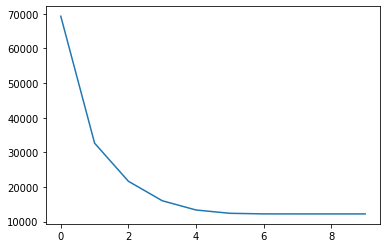

In [10]:
import matplotlib.pyplot as plt
plt.plot(objvals)

In [11]:
beta_hat

array([-0.60081137, -1.11699943,  1.18280741,  0.67081184,  0.66972214, -1.7050926 ,  0.87667438,
       -0.69162028,  1.22498276, -0.19295167, -0.57348698,  0.4438535 ,  1.58654734,  0.95466432,
        0.35391181, -0.64090597, -0.17474585,  1.02542448,  0.97981925, -0.21859861,  0.24757379,
       -1.95900962,  0.95583415, -0.46660488, -1.31970033, -1.07853375, -0.96233439, -0.49092673,
       -0.3885543 ,  0.11810773,  0.73827597,  0.41778154,  0.77903403,  0.14037218, -0.20613105,
        1.33428288, -0.83007447, -1.58758058, -0.04096082,  0.0541461 , -0.00642397, -0.33036421,
       -1.77087006, -1.35171751, -1.5966188 , -1.29920738,  0.97837832,  0.94548003, -0.84784072,
       -1.07477454, -0.65768838, -1.52644047, -1.44272699, -1.41389125,  0.07668639, -2.07684364,
        0.23669264, -1.45794974, -0.4810764 , -1.11145764,  1.22263435,  0.71045908,  0.45432555,
       -0.20531513,  1.18659728, -0.16870397,  0.41973803,  0.47919672, -0.27444064, -0.92214026,
       -2.52772108, 

In [12]:
beta

array([-0.58441387, -1.11534971,  1.15570434,  0.68635474,  0.64559564, -1.70989894,  0.87296263,
       -0.69061605,  1.21015702, -0.17972039, -0.59593691,  0.45252029,  1.55835773,  0.93393225,
        0.33544231, -0.62751865, -0.16601382,  1.03999001,  0.99253053, -0.22189606,  0.26883567,
       -1.95555529,  0.93138627, -0.47006585, -1.30103516, -1.0852571 , -0.92710125, -0.46948194,
       -0.41250335,  0.09711287,  0.73781056,  0.43563306,  0.78146188,  0.09794209, -0.20673932,
        1.3563857 , -0.84334031, -1.57440936, -0.02785942,  0.04491426, -0.00378645, -0.32005209,
       -1.73699327, -1.35755085, -1.61153494, -1.29018054,  0.92198227,  0.92329806, -0.87182087,
       -1.11109253, -0.64117813, -1.54063266, -1.47551246, -1.40012474,  0.05626203, -2.06673395,
        0.24069911, -1.45962908, -0.49910593, -1.08548   ,  1.22895895,  0.71943325,  0.47494861,
       -0.21579343,  1.19116701, -0.19017216,  0.4216233 ,  0.48972018, -0.2864368 , -0.92757763,
       -2.54487881, 

### 3. 梯度下降法迭代

迭代公式为 $\beta^{new}=\beta^{old}-\alpha\cdot n^{-1}X'(prob-y)$，其中 $prob$ 是 $\rho(X\beta^{old})$ 组成的向量。

In [13]:
def compute_obj_grad(part_mat, beta_old):
    # 提取 X 和 y
    y = part_mat[:, 0]
    x = part_mat[:, 1:]
    # X * beta
    xb = x.dot(beta_old)
    # rho(X * beta)
    prob = expit(xb)
    # 目标函数：sum(y * log(prob) + (1 - y) * log(1 - prob)) 取log所以防止接近0
    obj = -np.sum(y * np.log(prob + 1e-8) + (1.0 - y) * np.log(1.0 - prob + 1e-8))
    # 梯度：X'(prob - y)
    grad = x.transpose().dot(prob - y)
    # 该分块的样本量
    ni = x.shape[0]
    return ni, obj, grad

主循环：

In [14]:
import time

# 根据数据动态获取维度，不要使用之前模拟时的变量
p = dat.first().shape[1] - 1
# beta 初始化为 0 向量
beta_hat2 = np.zeros(p)
# 记录目标函数值
objvals = []

# 最大迭代次数
maxit = 100
# 步长
step_size = 10.0
# 收敛条件
eps = 1e-5

t1 = time.time()
for i in range(maxit):
    # 完整数据的样本量和梯度是各分区的加和
    n, objfn, grad = dat.map(lambda part: compute_obj_grad(part, beta_hat2)).\
        reduce(lambda x, y: (x[0] + y[0], x[1] + y[1], x[2] + y[2]))
    objfn /= n
    grad /= n
    # 计算新 beta
    beta_new = beta_hat2 - step_size * grad
    # 计算梯度的变化
    grad_norm = np.linalg.norm(grad)
    beta_norm = np.linalg.norm(beta_hat2)
    print(f"Iteration {i}, objfn = {objfn}, grad_norm = {grad_norm}, beta_norm = {beta_norm}")
    objvals.append(objfn)
    # 如果梯度值较小，退出循环
    if grad_norm < eps or grad_norm < eps * beta_norm:
        break
    # 更新 beta
    beta_hat2 = beta_new
t2 = time.time()
print(f"\nfinished in {t2 - t1} seconds")

Iteration 0, objfn = 0.6931471605599453, grad_norm = 0.3936737955731282, beta_norm = 0.0
Iteration 1, objfn = 0.17950616436038194, grad_norm = 0.031619931547791455, beta_norm = 3.936737955731282
Iteration 2, objfn = 0.1707471024683261, grad_norm = 0.025383527519615347, beta_norm = 4.229491074256976
Iteration 3, objfn = 0.16469381927034402, grad_norm = 0.022392841191143965, beta_norm = 4.483061356681379
Iteration 4, objfn = 0.15994191805009847, grad_norm = 0.020095697896829853, beta_norm = 4.7069573090021795
Iteration 5, objfn = 0.1560914605394923, grad_norm = 0.018258205753545906, beta_norm = 4.907896894608809
Iteration 6, objfn = 0.152897837488854, grad_norm = 0.016748376887099004, beta_norm = 5.090465232475998
Iteration 7, objfn = 0.1502003244937587, grad_norm = 0.015481630776221285, beta_norm = 5.257937245323649
Iteration 8, objfn = 0.14788823548439792, grad_norm = 0.014400867947102373, beta_norm = 5.412743195401856
Iteration 9, objfn = 0.14588247717072558, grad_norm = 0.01346599318

Iteration 77, objfn = 0.12349611532649797, grad_norm = 0.00206175072176077, beta_norm = 8.987716462471678
Iteration 78, objfn = 0.12345396045747288, grad_norm = 0.002027514752028183, beta_norm = 9.008333258708701
Iteration 79, objfn = 0.12341319174428828, grad_norm = 0.0019940641345815714, beta_norm = 9.028607709041665
Iteration 80, objfn = 0.12337375508287568, grad_norm = 0.0019613733841397645, beta_norm = 9.048547666615898
Iteration 81, objfn = 0.12333559890834206, grad_norm = 0.0019294181239348587, beta_norm = 9.06816072973816
Iteration 82, objfn = 0.12329867405254823, grad_norm = 0.0018981750251317927, beta_norm = 9.087454252961106
Iteration 83, objfn = 0.12326293361107299, grad_norm = 0.001867621750219452, beta_norm = 9.106435357561931
Iteration 84, objfn = 0.12322833281885032, grad_norm = 0.0018377369000706061, beta_norm = 9.12511094145502
Iteration 85, objfn = 0.12319482893382788, grad_norm = 0.0018084999643941987, beta_norm = 9.143487688575183
Iteration 86, objfn = 0.1231623811

绘制目标函数变化曲线：

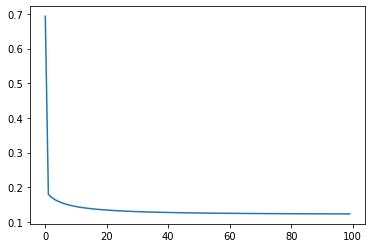

In [15]:
import matplotlib.pyplot as plt
plt.plot(objvals)

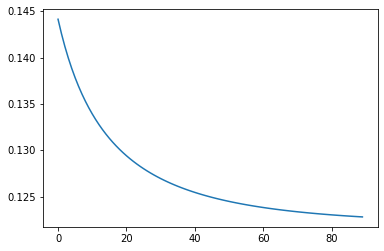

In [16]:
plt.plot(objvals[10:])

In [17]:
beta_hat[:10]

array([-0.60081137, -1.11699943,  1.18280741,  0.67081184,  0.66972214, -1.7050926 ,  0.87667438,
       -0.69162028,  1.22498276, -0.19295167])

In [ ]:
beta_hat2[:10]

关闭 Spark 连接：

In [ ]:
sc.stop()